# RescueTime Downloader

Code to collect and export RescueTime Activity Logs, includes options to collect in hourly or minute bins. Default is hourly.

**NOTE:** Collecting Full History takes some time, depending how many years of data you have. I recommend you configure the script below to pull data in yearly chunks, though it should work if you attempt to export full history. 

------

## Setup and Installation

* Go to [RescueTime API](https://www.rescuetime.com/anapi/manage) and copy an API Key 
* Copy credentials-sample.json to create credentials.json and add your RescueTime Key.
* This project depends on no additional code besides standard python libraries and Pandas. 

-----

## Dependencies

In [1]:
import requests
import os
from datetime import date, datetime, timedelta as td
import pandas as pd

----

## Credentials

In [2]:
import json

with open("credentials.json", "r") as file:
    credentials = json.load(file)
    rescuetime_cr = credentials['rescuetime']
    KEY = rescuetime_cr['KEY']

In [3]:
baseurl = 'https://www.rescuetime.com/anapi/data?key='

In [4]:
url =  baseurl + KEY

----

## Export Dates Configuration

In [5]:
# Configure These to Your Preferred Dates
start_date = '2019-06-29'  # Start date for data
end_date   = '2019-07-08'  # End date for data

------

## Function to Get RescueTime Activities

In [6]:
# Adjustable by Time Period
def rescuetime_get_activities(start_date, end_date, resolution='hour'):
    # Configuration for Query
    # SEE: https://www.rescuetime.com/apidoc
    payload = {
        'perspective':'interval',
        'resolution_time': resolution, #1 of "month", "week", "day", "hour", "minute"
        'restrict_kind':'overview', #'document',
        'restrict_begin': start_date,
        'restrict_end': end_date,
        'format':'json' #csv
    }
    
    # Setup Iteration - by Day
    d1 = datetime.strptime(payload['restrict_begin'], "%Y-%m-%d").date()
    d2 = datetime.strptime(payload['restrict_end'], "%Y-%m-%d").date()
    delta = d2 - d1
    
    activities_list = []
        
    # Iterate through the days, making a request per day
    for i in range(delta.days + 1):
        # Find iter date and set begin and end values to this to extract at once.
        d3 = d1 + td(days=i) # Add a day
        if d3.day == 1: print('Pulling Monthly Data for ', d3)

        # Update the Payload
        payload['restrict_begin'] = str(d3) # Set payload days to current
        payload['restrict_end'] = str(d3)   # Set payload days to current

        # Request
        try: 
            r = requests.get(url, payload) # Make Request
            iter_result = r.json() # Parse result
            # print("Collecting Activities for " + str(d3))
        except: 
            print("Error collecting data for " + str(d3))
    
        for i in iter_result['rows']:
            activities_list.append(i)
            
    return activities_list

---

## Collect Report of Activites By Minute

In [50]:
activities_minute_log = rescuetime_get_activities(start_date, end_date, 'minute')

Pulling Monthly Data for  2019-07-01


In [51]:
activities_per_minute = pd.DataFrame.from_dict(activities_minute_log)

In [52]:
activities_per_minute.head()

,0,1,2,3
0,2019-06-29T07:20:00,124,1,Utilities
1,2019-06-29T07:20:00,58,1,Uncategorized
2,2019-06-29T07:20:00,37,1,Software Development
3,2019-06-29T07:25:00,295,1,Software Development
4,2019-06-29T07:25:00,5,1,Utilities


In [53]:
# 'restrict_kind':'overview', #'document',
# activities_per_minute.columns = ['Date', 'Seconds', 'NumberPeople', 'Activity', 'Document', 'Category', 'Productivity']

# 'restrict_kind':'overview'
activities_per_minute.columns = ['Date', 'Seconds', 'NumberPeople', 'Overview']


In [54]:
activities_per_minute['Date'] = pd.to_datetime(activities_per_minute['Date'])
activities_per_minute.dtypes

Date            datetime64[ns]
Seconds                  int64
NumberPeople             int64
Overview                object
dtype: object

In [55]:
activities_per_minute.sort_values('Date', ascending = False).head()

,Date,Seconds,NumberPeople,Overview
2368,2019-07-07 18:05:00,68,1,Communication & Scheduling
2367,2019-07-07 18:05:00,178,1,Software Development
2366,2019-07-07 18:00:00,5,1,Reference & Learning
2365,2019-07-07 18:00:00,62,1,Communication & Scheduling
2364,2019-07-07 18:00:00,293,1,Software Development


# Data Prep

In [69]:
# Dataframe Minimum Requirement: Start Date, End Date, and Category
data = activities_per_minute.copy()

data['Seconds Sum Per 5Min'] = data.groupby(['Date'])['Seconds'].apply(lambda x: x.cumsum())

data['Date End'] = data['Date'] + pd.to_timedelta(data['Seconds Sum Per 5Min'], unit='s')
data['Date Start'] = data['Date End'] - pd.to_timedelta(data['Seconds'], unit='s')

data['Date Abr'] = data['Date'].dt.date


In [70]:
data.sort_values('Date', ascending = False).head(10)

,Date,Seconds,NumberPeople,Overview,Seconds Sum Per 5Min,Date End,Date Start,Date Abr
2368,2019-07-07 18:05:00,68,1,Communication & Scheduling,246,2019-07-07 18:09:06,2019-07-07 18:07:58,2019-07-07
2367,2019-07-07 18:05:00,178,1,Software Development,178,2019-07-07 18:07:58,2019-07-07 18:05:00,2019-07-07
2366,2019-07-07 18:00:00,5,1,Reference & Learning,360,2019-07-07 18:06:00,2019-07-07 18:05:55,2019-07-07
2365,2019-07-07 18:00:00,62,1,Communication & Scheduling,355,2019-07-07 18:05:55,2019-07-07 18:04:53,2019-07-07
2364,2019-07-07 18:00:00,293,1,Software Development,293,2019-07-07 18:04:53,2019-07-07 18:00:00,2019-07-07
2362,2019-07-07 17:55:00,19,1,Design & Composition,372,2019-07-07 18:01:12,2019-07-07 18:00:53,2019-07-07
2360,2019-07-07 17:55:00,281,1,Software Development,281,2019-07-07 17:59:41,2019-07-07 17:55:00,2019-07-07
2361,2019-07-07 17:55:00,72,1,Communication & Scheduling,353,2019-07-07 18:00:53,2019-07-07 17:59:41,2019-07-07
2363,2019-07-07 17:55:00,2,1,Utilities,374,2019-07-07 18:01:14,2019-07-07 18:01:12,2019-07-07
2359,2019-07-07 17:50:00,39,1,Communication & Scheduling,400,2019-07-07 17:56:40,2019-07-07 17:56:01,2019-07-07


In [71]:
# Minimum Requirement: Start Date, End Date, and Category
df = data

### Step 0: Set Up Variables
start_date = '2019-06-29'  # Start date for data
end_date   = '2019-07-08'  # End date for data

# General Column Variable Names
start_date_column = 'Date Start'
end_date_column = 'Date End'
category_column = 'Overview' 

In [72]:
### Step 1: Find Data Gaps
# Create a temporary dataframe of the end dates
df_end = df[[end_date_column]].copy()

# Add a column category with the field value 'No Entry'
df_end[category_column] = 'No Entry'

# If there is no gap in data (as in there is an entry immediately following the previous),
# remove the the record from the df_end dataframe
start_date_pt_list = list(df[start_date_column].unique())
df_end = df_end[~df_end[end_date_column].isin(start_date_pt_list)]



### Step 2: Combine End and Start Dates into single column
# Create a two column data frame with the start date and the category
df_start = df[[start_date_column, category_column]].copy()

# Update column names to match that of df_start
df_end.rename(columns = {end_date_column: start_date_column}, inplace = True)
                         
# Add the df_end dataframe to the bottom
df_mini_entries = pd.concat([df_start, df_end])




### STEP 3: Expand Dataset - Every Minute
# Create a dataframe of minute intevals between two dates   
time_range = pd.date_range(start_date, end_date, freq= '1s')
time_range_df = pd.DataFrame(time_range).rename(columns = {0: 'date_time'})

# Convert to time
time_range_df['date_time'] = pd.to_datetime(time_range_df['date_time'])

# Replace time zone
# time_range_df['date_time'] = [row.replace(tzinfo=from_zone).astimezone(to_zone) for row in time_range_df['date_time']]

# Left Join our mini dataframe to this range 
df_minutes = pd.merge(time_range_df, df_mini_entries, how = 'left',  left_on = 'date_time', right_on = start_date_column)

# Find the first date_time with a category entry
date_of_first_entry = df_minutes[~df_minutes[category_column].isnull()]['date_time'].min()
# Find the index of the first entry
index_of_first_entry = df_minutes.index[df_minutes[start_date_column]==date_of_first_entry][0]

# Reduce the dataframe to begin with the first entry
df_minutes = df_minutes[index_of_first_entry:].copy()



### Step 4: Categorize every minute
# Forward fill the category until next entry
df_minutes[category_column] = df_minutes[category_column].ffill()

In [73]:
df_minutes.head()

,date_time,Date Start,Overview
26400,2019-06-29 07:20:00,2019-06-29 07:20:00,Utilities
26401,2019-06-29 07:20:01,NaT,Utilities
26402,2019-06-29 07:20:02,NaT,Utilities
26403,2019-06-29 07:20:03,NaT,Utilities
26404,2019-06-29 07:20:04,NaT,Utilities


# Chart Category Prep

In [74]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings("ignore")

In [75]:
fsize = 18
params = {
    'legend.fontsize': fsize*0.925, 
    'axes.labelsize': fsize, 
    'axes.titlesize':fsize, 
    'xtick.labelsize':fsize, 
    'ytick.labelsize':fsize,
    'lines.linewidth' : 3,
    'figure.titlesize': fsize *1.2,
    'figure.figsize' : (8,8)
} 
plt.rcParams.update(params) 
plt.close('all') 

20


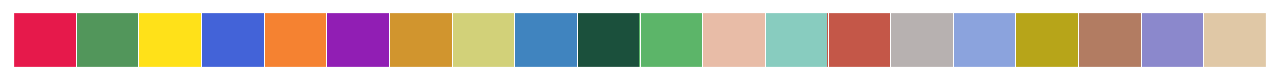

In [76]:
color_palette_p = [
    '#e6194b', 
    '#52965b', 
    '#ffe119', 
    '#4363d8', 
    '#f58231',
      
    '#911eb4', 
    '#d1952e',
    "#D2D179",
    "#4084BF",
    "#1B503C",
    
    "#5cb569",
    "#e8bca7",
    "#88ccbf",
    '#c45748',
    '#b7b1b0',
    
    '#8ba3dd',
    '#b7a519',
    '#b27c62',
    '#8b88cc', 
    '#e0c8a6'
]
print(len(color_palette_p))
sns.palplot(color_palette_p)

# pal50 = sns.color_palette(color_palette_p, 50)
# len(pal50)

In [77]:
# Set up variables
d = df_minutes
category_column = category_column
specified_category_entries = ['Entertainment', 'Software Development'] #, 'Social Networking']
date_time_column = 'date_time'

date_range_start = '2019-06-28'
date_range_end = '2019-07-08'

colors = color_palette_p

In [81]:
d = d[(d[date_time_column] >= date_range_start) & (d[date_time_column] <= date_range_end)].copy()

### X & Y Axis
# x-axis time periods
d['Date Abr'] = d['date_time'].dt.date

# y-axis scaled for 24 hour period
d['time_from_day_start'] = (d[date_time_column] - d[date_time_column].dt.normalize()).dt.total_seconds().fillna(0)/(60*60)

### Colors & Categories
category_list = list(d[category_column].unique())
category_list_minus = category_list
category_list_minus.remove('No Entry') 
# Zip colors
color_pairs = dict(zip(category_list_minus, colors))

# from itertools import zip_longest
# color_pairs  = dict(zip_longest(category_list, color_palette_p, fillvalue = '#e0c8a6'))


### Select Categories                              
# Create a list where all but the specified entries are included
category_list_remaining = category_list.copy()
[category_list_remaining.remove(x) for x in specified_category_entries]
# Convert all the not specified entries to the same color (make it easier to visually inspect for patterns)
color_pairs.update(dict.fromkeys(category_list_remaining, '#e8e8e8'))

# Add back in 'No Entry' with specified color
color_pairs['No Entry'] = '#ffffff'
# Ordered categories and colors
category_list_names_ordered = [key for (key, value) in sorted(color_pairs.items())]
color_palette = [value for (key, value) in sorted(color_pairs.items())]

In [82]:
d.head()

,date_time,Date Start,Overview,time_from_day_start,Date Abr
26400,2019-06-29 07:20:00,2019-06-29 07:20:00,Utilities,7.333333,2019-06-29
26401,2019-06-29 07:20:01,NaT,Utilities,7.333611,2019-06-29
26402,2019-06-29 07:20:02,NaT,Utilities,7.333889,2019-06-29
26403,2019-06-29 07:20:03,NaT,Utilities,7.334167,2019-06-29
26404,2019-06-29 07:20:04,NaT,Utilities,7.334444,2019-06-29


# Chart

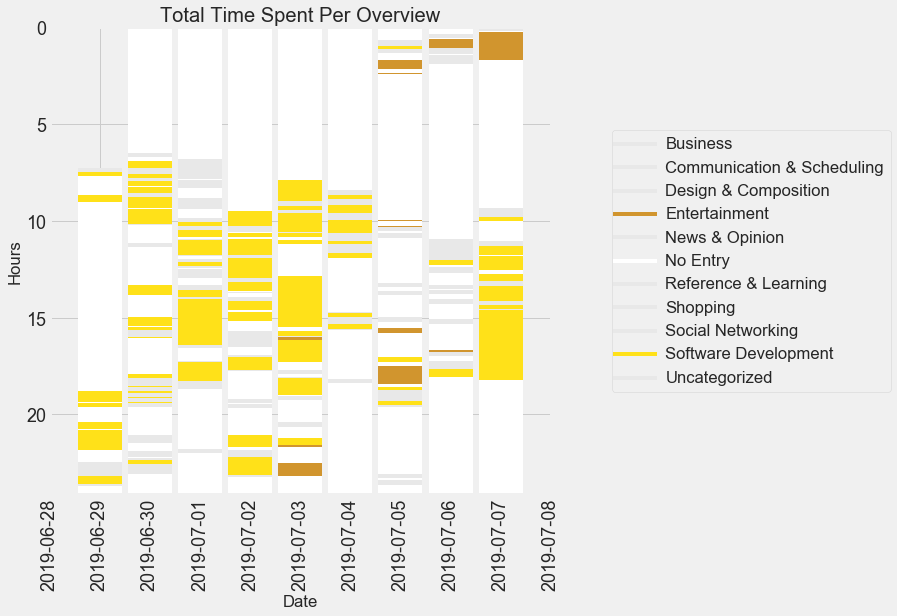

In [101]:
alpha_strength = .5

plt.style.use('fivethirtyeight')

for i in range(len(category_list)):
    plt.scatter(d[d[category_column] == category_list_names_ordered[i]]['Date Abr'], 
            d[d[category_column] == category_list_names_ordered[i]]['time_from_day_start'], 
            s = 2000,
            c=color_palette[i],
#             alpha=alpha_strength,
            marker = '_',
            )
plt.xticks(rotation=90)
plt.xlim(date_range_start, date_range_end)


plt.legend(category_list_names_ordered, bbox_to_anchor=(1.4,0.5), loc="center")
plt.ylabel('Hours')
plt.gca().invert_yaxis()
plt.xlabel('Date')
plt.title('Total Time Spent Per ' + category_column)
plt.show()

## Stacked Plot

In [84]:
import numpy as np


In [ ]:
[]

In [85]:
data.head()

,Date,Seconds,NumberPeople,Overview,Seconds Sum Per 5Min,Date End,Date Start,Date Abr
0,2019-06-29 07:20:00,124,1,Utilities,124,2019-06-29 07:22:04,2019-06-29 07:20:00,2019-06-29
1,2019-06-29 07:20:00,58,1,Uncategorized,182,2019-06-29 07:23:02,2019-06-29 07:22:04,2019-06-29
2,2019-06-29 07:20:00,37,1,Software Development,219,2019-06-29 07:23:39,2019-06-29 07:23:02,2019-06-29
3,2019-06-29 07:25:00,295,1,Software Development,295,2019-06-29 07:29:55,2019-06-29 07:25:00,2019-06-29
4,2019-06-29 07:25:00,5,1,Utilities,300,2019-06-29 07:30:00,2019-06-29 07:29:55,2019-06-29


In [96]:
# Choose wich columns to aggregate over
values_column_name = 'Seconds'

# List of all dates, ordered
date_list = list(data['Date Abr'].unique())
date_list.sort()

objects = date_list
pos = np.arange(len(date_list))

# Select the categories to focus on
category_list_alt = specified_category_entries

d2_alt = data[data[category_column].isin(category_list_alt)].groupby([category_column, 'Date Abr'])[values_column_name].sum().reset_index()
d2_alt['hours'] = d2_alt[values_column_name]/(60*60)

# Select the colors that match the cat_color pairings
cat_color_pairs_alt = {item: color_pairs.get(item) for item in category_list_alt}
colors_alt = list(cat_color_pairs_alt.values())


# STACKED BAR PLOT: Pivot Table
# Create a pivot table in order to create a stacked bar chart
pivot_d2 = d2_alt.pivot(index='Date Abr', columns=category_column, values='hours')


In [97]:
d2_alt.head()

,Overview,Date Abr,Seconds,hours
0,Entertainment,2019-06-29,61,0.016944
1,Entertainment,2019-06-30,2072,0.575556
2,Entertainment,2019-07-01,494,0.137222
3,Entertainment,2019-07-02,938,0.260556
4,Entertainment,2019-07-03,6366,1.768333


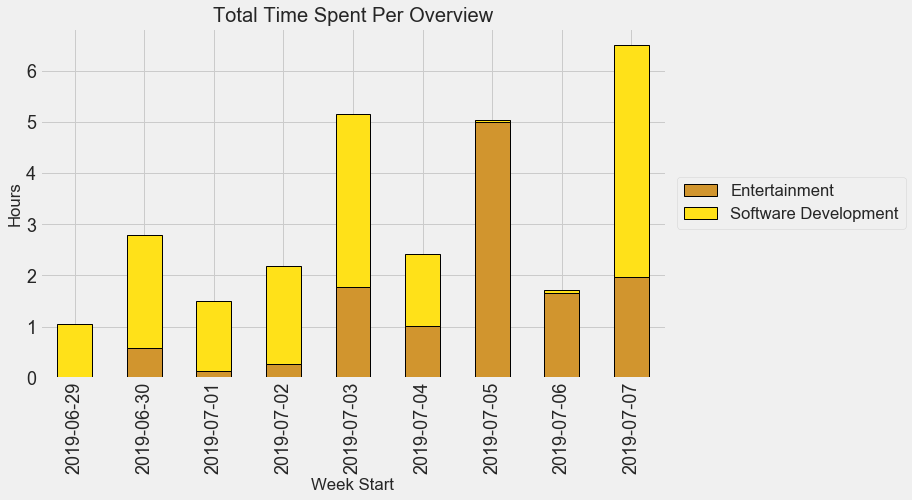

In [99]:
pivot_d2.plot.bar(stacked=True, 
                  color = colors_alt, 
                  figsize=(10,6),
                  edgecolor = 'black', 
                  linewidth = 1)

plt.xticks(pos, objects)
plt.xticks(rotation=90)
plt.legend(category_list_alt , bbox_to_anchor=(1.2,0.5), loc="center")


plt.ylabel('Hours')
plt.xlabel('Week Start')
plt.title('Total Time Spent Per ' + category_column)
plt.show()
